# 03 - Transfer Learning: Pre-entrenamiento Multi-Sujeto con Leave-One-Subject-Out

Este notebook implementa **Transfer Learning**: Pre-entrenamiento Multi-Sujeto con Fine-tuning Progresivo y Leave-One-Subject-Out (LOSO) cross-validation.

## Objetivos

1. **Pre-entrenar** el modelo CNN-LSTM con datos de múltiples sujetos (N-1 sujetos)
2. **Fine-tune** el modelo para cada sujeto individual usando fine-tuning progresivo
3. **Evaluar** usando Leave-One-Subject-Out cross-validation
4. **Comparar** resultados con y sin transfer learning

## Estrategia Implementada

### Fase 1: Pre-entrenamiento Multi-Sujeto
- Entrenar modelo completo con datos de 14 sujetos
- Aprender características generales de señales EEG
- Guardar pesos del modelo pre-entrenado

### Fase 2: Fine-tuning Progresivo (por sujeto)
- Etapa 1: Congelar CNN, fine-tune solo capas Dense
- Etapa 2: Descongelar LSTM + Dense, fine-tune
- Etapa 3: Descongelar últimas capas CNN + LSTM + Dense, fine-tune
- Etapa 4: Fine-tune completo con learning rate muy bajo

### Fase 3: Leave-One-Subject-Out Cross-Validation
- Para cada sujeto (15 iteraciones):
  - Pre-entrenar con 14 sujetos
  - Fine-tune para el sujeto restante
  - Evaluar en el sujeto de prueba
- Reportar métricas promedio y por sujeto

**Nota**: Este proceso puede tomar un buen tiempo en ejecutarse completamente debido a:
- Pre-entrenamiento con múltiples sujetos
- Fine-tuning progresivo por cada sujeto
- 15 iteraciones de Leave-One-Subject-Out


## 1. Importaciones y Configuración


In [121]:
# Importaciones
import numpy as np
from pathlib import Path
import warnings
import json
import time
from datetime import datetime
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight

from scipy import interpolate
from scipy.io import loadmat

# Para carga de archivos EEGLAB (.set)
try:
    import mne
    mne.set_log_level('ERROR')  # Suprimir mensajes informativos
except ImportError:
    print("Instalando mne...")
    import subprocess
    subprocess.check_call(["pip", "install", "-q", "mne"])
    import mne
    mne.set_log_level('ERROR')  # Suprimir mensajes informativos

# Función auxiliar para leer archivos EEGLAB (.set)
def load_eeglab_file(file_path, return_all_epochs=False):
    """Lee archivos EEGLAB (.set) usando MNE.
    
    Args:
        file_path: Ruta al archivo .set
        return_all_epochs: Si True, retorna todas las epochs como lista de arrays 2D.
                          Si False, retorna solo la primera epoch como array 2D.
    
    Returns:
        Si return_all_epochs=False: array 2D (n_channels, n_times)
        Si return_all_epochs=True: lista de arrays 2D [(n_channels, n_times), ...]
    """
    try:
        # Método 1: Intentar leer como epochs (más común en EEGLAB)
        try:
            epochs = mne.read_epochs_eeglab(str(file_path), verbose=False)
            epochs_data = epochs.get_data()  # Formato: (n_epochs, n_channels, n_times)
            
            if len(epochs_data.shape) == 3:
                n_epochs, n_channels, n_times = epochs_data.shape
                
                if return_all_epochs:
                    # Retornar todas las epochs como lista de arrays 2D
                    return [epochs_data[i] for i in range(n_epochs)]
                else:
                    # Retornar solo la primera epoch
                    return epochs_data[0]  # (n_channels, n_times)
            else:
                # Si no es 3D, intentar otro método
                raise ValueError(f"Formato inesperado de epochs: {epochs_data.shape}")
                
        except Exception as epochs_error:
            # Método 2: Intentar leer como raw (datos continuos)
            try:
                raw = mne.io.read_raw_eeglab(str(file_path), preload=True, verbose=False)
                data = raw.get_data()  # Formato: (n_channels, n_times)
                
                if return_all_epochs:
                    return [data]  # Retornar como lista con un solo elemento
                else:
                    return data
                    
            except Exception as raw_error:
                # Método 3: Usar scipy.io.loadmat como fallback
                from scipy.io import loadmat
                mat = loadmat(str(file_path), simplify_cells=False)
                
                # Buscar estructura EEG
                if 'EEG' not in mat:
                    raise ValueError(f"Campo 'EEG' no encontrado en {file_path.name}")
                
                eeg_struct = mat['EEG']
                if not isinstance(eeg_struct, np.ndarray) or eeg_struct.size == 0:
                    raise ValueError(f"Estructura EEG vacía en {file_path.name}")
                
                # Acceder al objeto EEG
                eeg_item = eeg_struct[0, 0] if eeg_struct.ndim >= 2 else eeg_struct.item()
                
                # Extraer el campo 'data'
                if not hasattr(eeg_item, 'dtype') or not eeg_item.dtype.names or 'data' not in eeg_item.dtype.names:
                    raise ValueError(f"Campo 'data' no encontrado en estructura EEG")
                
                data_field = eeg_item['data']
                data = np.asarray(data_field, dtype=np.float64)
                
                # Manejar diferentes formatos
                if len(data.shape) == 2:
                    # (n_channels, n_times) o (n_times, n_channels)
                    if return_all_epochs:
                        return [data]
                    else:
                        return data
                elif len(data.shape) == 3:
                    # (n_epochs, n_channels, n_times)
                    if return_all_epochs:
                        return [data[i] for i in range(data.shape[0])]
                    else:
                        return data[0]
                else:
                    raise ValueError(f"Formato de datos no soportado: {data.shape}")
                    
    except Exception as e:
        raise ValueError(f"Error al leer archivo {file_path}: {e}")

# Para descarga de Google Drive y manejo de ZIP
try:
    import gdown
except ImportError:
    print("Instalando gdown...")
    import subprocess
    subprocess.check_call(["pip", "install", "-q", "gdown"])
    import gdown

import zipfile
import shutil

print("Importaciones completadas")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")


Importaciones completadas
TensorFlow version: 2.16.2
GPU disponible: False


In [122]:
# Configuración del proyecto
CONFIG = {
    'n_subjects': 15,
    'n_channels': 64,
    'n_trials_per_subject': 22,  # 11 left + 11 right según el dataset
    'n_total_trials': 660,
    'sampling_rate': 128,
    'trial_duration': 9.0,
    'trial_window': (-3.0, 6.0),
    'n_samples_per_trial': 1152,
    'filter_low': 8,
    'filter_high': 30,
    'random_seed': 42,
    'data_dir': 'data',
    'models_dir': 'models',
    'results_dir': 'results',
    
    # Configuración de Transfer Learning
    'pretrain_epochs': 30,  # Épocas para pre-entrenamiento (reducido para optimización)
    'finetune_epochs_stage1': 5,  # Dense layers (muy reducido para optimización)
    'finetune_epochs_stage2': 6,  # LSTM + Dense (muy reducido para optimización)
    'finetune_epochs_stage3': 7,  # CNN final + LSTM + Dense (muy reducido para optimización)
    'finetune_epochs_stage4': 8,  # Fine-tune completo (muy reducido para optimización)
    'finetune_early_stopping_patience': 2,  # Patience muy agresivo (detener después de 2 épocas sin mejora)
    'finetune_min_delta': 1e-4,  # Mejora mínima requerida más grande (detener antes)
    'finetune_skip_stages': True,  # Si True, permite saltar etapas si ya convergió
    
    'pretrain_lr': 0.001,
    'finetune_lr_stage1': 0.0005,
    'finetune_lr_stage2': 0.0003,
    'finetune_lr_stage3': 0.0001,
    'finetune_lr_stage4': 0.00005,
    
    'batch_size': 128,  # Aumentado significativamente para reducir pasos por época (1133 → ~283)
    'validation_split': 0.15,  # Reducido para más datos de entrenamiento y menos validación
    'early_stopping_patience': 5,  # Reducido para detener más rápido
    'pretrain_min_delta': 1e-5,  # Mejora mínima requerida para early stopping
    
    # Data augmentation
    'use_augmentation': True,
    'augmentation_factor': 1,  # Reducido de 2 a 1 para menos datos y menos pasos (solo una ronda de augmentation)
    
    # Configuración para LSTM windowing
    'window_size': 128,  # Tamaño de ventana temporal
    'window_overlap': 0.25,  # Solapamiento entre ventanas (25% - reducido para crear menos ventanas)
    
    # Configuración de Google Drive
    'google_drive_folder_id': '1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW',
    'google_drive_url': 'https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW?usp=drive_link',
    # Nombres esperados de los archivos ZIP en Google Drive
    'zip_left_names': ['imag_left.zip', 'left_imag.zip', 'left.zip'],
    'zip_right_names': ['imag_right.zip', 'right_imag.zip', 'right.zip']
}

# Crear directorios necesarios
for dir_name in [CONFIG['data_dir'], CONFIG['models_dir'], CONFIG['results_dir']]:
    Path(dir_name).mkdir(exist_ok=True, parents=True)
Path(CONFIG['data_dir']).joinpath('processed').mkdir(exist_ok=True, parents=True)
Path(CONFIG['data_dir']).joinpath('left_imag').mkdir(exist_ok=True, parents=True)
Path(CONFIG['data_dir']).joinpath('right_imag').mkdir(exist_ok=True, parents=True)

print("Configuración cargada")
print(f"- Número de sujetos: {CONFIG['n_subjects']}")
print(f"- Épocas pre-entrenamiento: {CONFIG['pretrain_epochs']}")
print(f"- Épocas fine-tuning (por etapa): {CONFIG['finetune_epochs_stage1']}, {CONFIG['finetune_epochs_stage2']}, {CONFIG['finetune_epochs_stage3']}, {CONFIG['finetune_epochs_stage4']}")


Configuración cargada
- Número de sujetos: 15
- Épocas pre-entrenamiento: 30
- Épocas fine-tuning (por etapa): 5, 6, 7, 8


## 2. Funciones Auxiliares


In [123]:
# Funciones auxiliares para métricas y visualización
def calculate_metrics(y_true, y_pred):
    """Calcula todas las métricas de evaluación"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred)
    }
    return metrics

def plot_confusion_matrix(y_true, y_pred, title="Matriz de Confusión"):
    """Visualiza la matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['MI-L', 'MI-R'], 
                yticklabels=['MI-L', 'MI-R'])
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title(title)
    plt.tight_layout()
    return plt.gcf()

print("Funciones auxiliares definidas")


Funciones auxiliares definidas


## 3. Carga de Datos con Rastreo de Sujetos (para LOSO)


In [124]:
def download_data_from_drive(data_dir='data', folder_id=None, config=None):
    """Descarga archivos ZIP del Google Drive y los extrae en las carpetas correspondientes"""
    if config is None:
        config = CONFIG
    if folder_id is None:
        folder_id = config.get('google_drive_folder_id', '1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW')
    
    data_path = Path(data_dir)
    left_dir = data_path / 'left_imag'
    right_dir = data_path / 'right_imag'
    
    # Crear directorios si no existen
    left_dir.mkdir(exist_ok=True, parents=True)
    right_dir.mkdir(exist_ok=True, parents=True)
    
    # Verificar si ya existen archivos
    # Verificar si ya existen archivos (formato EEGLAB: .set y .fdt)
    # Nota: Los archivos .fdt son binarios asociados a .set, solo contamos .set
    left_files = list(left_dir.glob('*.set'))
    right_files = list(right_dir.glob('*.set'))
    
    if len(left_files) > 0 and len(right_files) > 0:
        print(f"Datos encontrados: {len(left_files)} archivos en left_imag, {len(right_files)} archivos en right_imag")
        return
    
    print("No se encontraron datos locales. Descargando ZIPs del Google Drive...")
    print(f"URL: {config.get('google_drive_url', 'N/A')}")
    
    try:
        # Descargar carpeta completa del Google Drive
        print("Descargando carpeta desde Google Drive...")
        print("Esto puede tomar varios minutos...")
        
        # Descargar la carpeta completa (esto descargará todos los archivos, incluyendo los ZIP)
        temp_download_dir = data_path / 'temp_downloads'
        temp_download_dir.mkdir(exist_ok=True, parents=True)
        
        gdown.download_folder(
            id=folder_id,
            output=str(temp_download_dir),
            quiet=False,
            use_cookies=False
        )
        
        # Buscar archivos ZIP descargados
        zip_files = list(temp_download_dir.glob('*.zip'))
        
        if len(zip_files) == 0:
            # Buscar recursivamente en subcarpetas
            zip_files = list(temp_download_dir.rglob('*.zip'))
        
        print(f"Encontrados {len(zip_files)} archivo(s) ZIP")
        
        # Identificar y extraer cada ZIP
        left_zip = None
        right_zip = None
        
        # Buscar ZIPs por nombre
        zip_left_names = config.get('zip_left_names', ['imag_left.zip', 'left_imag.zip', 'left.zip'])
        zip_right_names = config.get('zip_right_names', ['imag_right.zip', 'right_imag.zip', 'right.zip'])
        
        for zip_file in zip_files:
            zip_name_lower = zip_file.name.lower()
            # Buscar ZIP izquierdo
            if not left_zip:
                for name_pattern in zip_left_names:
                    if name_pattern.lower() in zip_name_lower or 'left' in zip_name_lower:
                        left_zip = zip_file
                        print(f"Identificado ZIP izquierdo: {zip_file.name}")
                        break
            # Buscar ZIP derecho
            if not right_zip:
                for name_pattern in zip_right_names:
                    if name_pattern.lower() in zip_name_lower or 'right' in zip_name_lower:
                        right_zip = zip_file
                        print(f"Identificado ZIP derecho: {zip_file.name}")
                        break
        
        # Si no se encontraron por nombre, intentar usar los primeros dos ZIPs
        if not left_zip and len(zip_files) >= 2:
            left_zip = zip_files[0]
            right_zip = zip_files[1]
            print(f"Usando primeros dos ZIPs encontrados: {left_zip.name}, {right_zip.name}")
        elif not left_zip and len(zip_files) == 1:
            print(f"Solo se encontró un ZIP: {zip_files[0].name}")
            print("Asumiendo que contiene ambos conjuntos de datos...")
            left_zip = zip_files[0]
        
        # Extraer ZIPs de manera inteligente (evitar carpetas anidadas)
        def extract_zip_smartly(zip_file, target_dir, zip_name):
            """Extrae un ZIP evitando crear carpetas anidadas"""
            temp_extract = target_dir.parent / f'temp_extract_{zip_name}'
            temp_extract.mkdir(exist_ok=True, parents=True)
            
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(temp_extract)
            
            # Buscar si hay una carpeta left_imag o right_imag en la raíz
            nested_dir = None
            for item in temp_extract.iterdir():
                if item.is_dir() and (item.name.lower() in ['left_imag', 'right_imag', 'left', 'right']):
                    nested_dir = item
                    break
            
            # Si encontramos una carpeta anidada, mover su contenido
            if nested_dir:
                print(f"Detectada carpeta '{nested_dir.name}' dentro del ZIP")
                # Mover todos los archivos de la carpeta anidada
                for file in nested_dir.rglob('*'):
                    if file.is_file():
                        relative = file.relative_to(nested_dir)
                        target_file = target_dir / relative
                        target_file.parent.mkdir(parents=True, exist_ok=True)
                        shutil.move(str(file), str(target_file))
                print(f"Contenido movido de {nested_dir.name} a {target_dir.name}/")
            else:
                # Si no hay carpeta anidada, mover todos los archivos directamente
                for file in temp_extract.rglob('*'):
                    if file.is_file():
                        relative = file.relative_to(temp_extract)
                        target_file = target_dir / relative
                        target_file.parent.mkdir(parents=True, exist_ok=True)
                        shutil.move(str(file), str(target_file))
            
            # Limpiar directorio temporal
            shutil.rmtree(temp_extract)
        
        if left_zip:
            print(f"Extrayendo {left_zip.name} a left_imag/...")
            extract_zip_smartly(left_zip, left_dir, 'left')
            print("Extracción completada: left_imag/")
        
        if right_zip:
            print(f"Extrayendo {right_zip.name} a right_imag/...")
            extract_zip_smartly(right_zip, right_dir, 'right')
            print("Extracción completada: right_imag/")
        
        # Limpiar archivos temporales
        if temp_download_dir.exists():
            shutil.rmtree(temp_download_dir)
            print("Archivos temporales eliminados")
        
        # Verificar archivos extraídos (formato EEGLAB: .set y .fdt)
        # Nota: Los archivos .fdt son binarios asociados a .set, solo contamos .set
        downloaded_left = list(left_dir.glob('*.set'))
        downloaded_right = list(right_dir.glob('*.set'))
        
        if len(downloaded_left) > 0 or len(downloaded_right) > 0:
            print("Descarga y extracción completada:")
            print(f"- left_imag: {len(downloaded_left)} archivos .set")
            print(f"- right_imag: {len(downloaded_right)} archivos .set")
            if len(downloaded_left) > 0:
                fdt_files_left = list(left_dir.glob('*.fdt'))
                if len(fdt_files_left) > 0:
                    print(f"- left_imag: {len(fdt_files_left)} archivos .fdt asociados")
            if len(downloaded_right) > 0:
                fdt_files_right = list(right_dir.glob('*.fdt'))
                if len(fdt_files_right) > 0:
                    print(f"- right_imag: {len(fdt_files_right)} archivos .fdt asociados")
        else:
            print("Los ZIPs se extrajeron pero no se encontraron archivos .set")
            print(f"Verifica la estructura de los archivos ZIP")
        
    except Exception as e:
        print(f"Error al descargar o extraer: {e}")
        print("Por favor, descarga los archivos ZIP manualmente desde:")
        print(f"{config.get('google_drive_url', 'N/A')}")
        print("Y extrae:")
        print(f"- imag_left.zip (o similar) en: {left_dir}/")
        print(f"- imag_right.zip (o similar) en: {right_dir}/")
        raise

def load_eeg_data_with_subjects(data_dir='data', config=None):
    """
    Carga datos EEG y rastrea qué trial pertenece a qué sujeto.
    
    Asume que los archivos están organizados de manera que podemos inferir el sujeto
    basándonos en el número de trial (ej: 22 trials por sujeto).
    
    Returns:
        X: array de trials (n_trials, n_channels, n_samples)
        y: array de etiquetas (n_trials,)
        subject_ids: array de IDs de sujetos (n_trials,)
    """
    if config is None:
        config = CONFIG
    
    data_path = Path(data_dir)
    left_dir = data_path / 'left_imag'
    right_dir = data_path / 'right_imag'
    
    X_all, y_all, subject_ids_all = [], [], []
    
    # Función auxiliar para extraer ID de sujeto del nombre del archivo
    def extract_subject_id(file_name):
        """
        Extrae el ID del sujeto del nombre del archivo.
        Espera formato como: S001_Task2_PREP_Left.set o S001_Task2_PREP_Right.set
        """
        import re
        # Buscar patrón S seguido de números (ej: S001, S002, S15)
        # El patrón busca 'S' seguido de 1-3 dígitos al inicio del nombre
        match = re.search(r'S(\d+)', str(file_name))
        if match:
            subject_num = int(match.group(1))
            subject_id = subject_num - 1  # Convertir a 0-indexed (S001 -> 0, S002 -> 1)
            return subject_id
        # Si no encuentra el patrón S, intentar buscar cualquier número al inicio
        match = re.search(r'^[^0-9]*(\d+)', str(file_name))
        if match:
            subject_num = int(match.group(1))
            return subject_num - 1
        return None
    
    # Función auxiliar para cargar archivos y asignar sujetos
    def load_trials_with_subjects(trial_dir, label):
        X_trials, y_trials, subject_trials = [], [], []
        subject_file_map = {}  # Para diagnóstico
        
        # Buscar archivos .set (formato EEGLAB)
        # Nota: Los archivos .fdt se cargan automáticamente con el .set cuando se usa MNE
        files = sorted(trial_dir.glob('*.set'))
        
        print(f"Encontrados {len(files)} archivos .set")
        
        for file_path in files:
            if not file_path.is_file():
                continue
            
            try:
                # Extraer ID del sujeto del nombre del archivo
                subject_id = extract_subject_id(file_path.name)
                if subject_id is None:
                    print(f"No se pudo extraer ID de sujeto de {file_path.name}, saltando...")
                    continue
                
                # Guardar mapeo para diagnóstico
                if subject_id not in subject_file_map:
                    subject_file_map[subject_id] = []
                subject_file_map[subject_id].append(file_path.name)
                
                # Debug: mostrar los primeros archivos procesados
                if len(subject_file_map) <= 5 and len(subject_file_map.get(subject_id, [])) <= 2:
                    print(f"{file_path.name} → Sujeto ID: {subject_id}")
                
                # Leer archivo EEGLAB (.set) - obtener todas las épocas
                epochs_list = load_eeglab_file(file_path, return_all_epochs=True)
                
                # Iterar sobre todas las épocas del archivo
                for epoch_data in epochs_list:
                    # Asegurar que es un array 2D
                    if len(epoch_data.shape) != 2:
                        continue
                    
                    # Asegurar formato correcto: (channels, time)
                    if epoch_data.shape[0] > epoch_data.shape[1]:
                        epoch_data = epoch_data.T
                    
                    # Ajustar a tamaño esperado
                    if epoch_data.shape[0] == config['n_channels'] and epoch_data.shape[1] >= config['n_samples_per_trial']:
                        epoch_data = epoch_data[:, :config['n_samples_per_trial']]
                    elif epoch_data.shape[1] == config['n_channels'] and epoch_data.shape[0] >= config['n_samples_per_trial']:
                        epoch_data = epoch_data[:config['n_samples_per_trial'], :].T
                    else:
                        continue
                    
                    # Validar tamaño final
                    if epoch_data.shape == (config['n_channels'], config['n_samples_per_trial']):
                        X_trials.append(epoch_data)
                        y_trials.append(label)
                        # Usar el ID del sujeto extraído del nombre del archivo
                        subject_trials.append(subject_id)
                    else:
                        continue
                        
            except Exception as e:
                print(f"Error cargando {file_path.name}: {e}")
                continue
        
        # Diagnóstico: mostrar distribución de archivos por sujeto
        if len(subject_file_map) > 0:
            print("Distribución de archivos por sujeto:")
            for subj_id in sorted(subject_file_map.keys()):
                files_for_subj = subject_file_map[subj_id]
                print(f"- Sujeto {subj_id}: {len(files_for_subj)} archivo(s)")
                if len(files_for_subj) <= 3:  # Mostrar nombres si hay pocos
                    for fname in files_for_subj:
                        print(f"{fname}")
        
        return X_trials, y_trials, subject_trials
    
    print("Cargando datos con identificación de sujetos...")
    
    # Cargar trials izquierdos
    X_left, y_left, subjects_left = load_trials_with_subjects(left_dir, label=0)
    unique_subjects_left = list(set(subjects_left))
    print(f"Left trials: {len(X_left)} trials de {len(unique_subjects_left)} sujetos únicos")
    print(f"IDs de sujetos encontrados: {sorted(unique_subjects_left)}")
    
    # Cargar trials derechos
    X_right, y_right, subjects_right = load_trials_with_subjects(right_dir, label=1)
    unique_subjects_right = list(set(subjects_right))
    print(f"Right trials: {len(X_right)} trials de {len(unique_subjects_right)} sujetos únicos")
    print(f"IDs de sujetos encontrados: {sorted(unique_subjects_right)}")
    
    # Si no hay datos, intentar descargarlos
    if len(X_left) == 0 or len(X_right) == 0:
        print(f"No se encontraron datos en las carpetas. Intentando descargar del Google Drive...")
        download_data_from_drive(data_dir, config.get('google_drive_folder_id'), config)
        
        # Intentar cargar nuevamente después de la descarga
        X_left, y_left, subjects_left = load_trials_with_subjects(left_dir, label=0)
        X_right, y_right, subjects_right = load_trials_with_subjects(right_dir, label=1)
    
    # Validar que ahora sí se encontraron datos reales
    if len(X_left) == 0:
        raise FileNotFoundError(
            f"ERROR: No se pudieron descargar ni encontrar datos reales en {left_dir}\n"
            f"   Por favor, descarga los datos manualmente desde:\n"
            f"   {config.get('google_drive_url', 'https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW')}\n"
            f"   Y colócalos en: {left_dir}/"
        )
    
    if len(X_right) == 0:
        raise FileNotFoundError(
            f"ERROR: No se pudieron descargar ni encontrar datos reales en {right_dir}\n"
            f"   Por favor, descarga los datos manualmente desde:\n"
            f"   {config.get('google_drive_url', 'https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW')}\n"
            f"   Y colócalos en: {right_dir}/"
        )
    
    print(f"Datos reales encontrados: {len(X_left)} trials izquierdos, {len(X_right)} trials derechos")
    
    # Combinar left y right
    X_all = X_left + X_right
    y_all = y_left + y_right
    subject_ids_all = subjects_left + subjects_right
    
    # Convertir a arrays numpy
    X = np.array(X_all)
    y = np.array(y_all)
    subject_ids = np.array(subject_ids_all)
    
    # Asegurar que los subject_ids estén en rango [0, n_subjects-1]
    unique_subjects = np.unique(subject_ids)
    print(f"\nAntes del mapeo: {len(unique_subjects)} sujetos únicos con IDs: {sorted(unique_subjects)}")
    
    # Crear mapeo para normalizar IDs a [0, n_subjects-1]
    subject_id_mapping = {old_id: new_id for new_id, old_id in enumerate(sorted(unique_subjects))}
    print(f"Mapeo de IDs: {subject_id_mapping}")
    
    subject_ids = np.array([subject_id_mapping[old_id] for old_id in subject_ids])
    
    unique_subjects_final = np.unique(subject_ids)
    print(f"\nDatos cargados exitosamente:")
    print(f"- Shape de X: {X.shape}")
    print(f"- Número de trials: {len(y)}")
    print(f"- Sujetos únicos: {len(unique_subjects_final)}")
    print(f"- IDs de sujetos (final): {sorted(unique_subjects_final)}")
    print(f"- Distribución por sujeto: {np.bincount(subject_ids)}")
    print(f"- Distribución por clase: {np.bincount(y)}")
    
    return X, y, subject_ids

print("Función de carga de datos con sujetos definida")


Función de carga de datos con sujetos definida


In [125]:
# Funciones de data augmentation para señales EEG
def add_gaussian_noise(trial, noise_factor=0.1):
    """Añade ruido gaussiano a la señal EEG"""
    noise = np.random.normal(0, noise_factor, trial.shape)
    return trial + noise

def time_warp(trial, sigma=0.2, knot=4):
    """Aplica time warping (estiramiento/compresión temporal)"""
    orig_steps = np.arange(trial.shape[-1])
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2,))
    warp_steps = (np.ones((knot + 2,)) * (trial.shape[-1] - 1) / (knot + 1)).cumsum()
    warp_steps[0] = 0
    warp_steps[-1] = trial.shape[-1] - 1
    warp_steps_new = warp_steps * random_warps
    warp_steps_new = np.clip(warp_steps_new, 0, trial.shape[-1] - 1)
    warped_trial = np.zeros_like(trial)
    for channel in range(trial.shape[0]):
        try:
            f = interpolate.interp1d(warp_steps_new, trial[channel, :][warp_steps_new.astype(int)],
                                     kind='cubic', fill_value='extrapolate', bounds_error=False)
            warped_trial[channel, :] = f(orig_steps)
        except:
            f = interpolate.interp1d(warp_steps_new, trial[channel, :][warp_steps_new.astype(int)],
                                     kind='linear', fill_value='extrapolate', bounds_error=False)
            warped_trial[channel, :] = f(orig_steps)
    return warped_trial

def amplitude_scale(trial, min_scale=0.8, max_scale=1.2):
    """Escala la amplitud de la señal"""
    scale_factor = np.random.uniform(min_scale, max_scale)
    return trial * scale_factor

def time_shift(trial, max_shift=None):
    """Desplaza la señal temporalmente"""
    if max_shift is None:
        max_shift = trial.shape[-1] // 10
    shift = np.random.randint(-max_shift, max_shift)
    shifted_trial = np.roll(trial, shift, axis=-1)
    return shifted_trial

def channel_dropout(trial, drop_prob=0.1):
    """Elimina aleatoriamente algunos canales (pone en cero)"""
    augmented = trial.copy()
    n_channels_to_drop = int(trial.shape[0] * drop_prob)
    if n_channels_to_drop > 0:
        channels_to_drop = np.random.choice(
            trial.shape[0],
            size=n_channels_to_drop,
            replace=False
        )
        augmented[channels_to_drop, :] = 0
    return augmented

def augment_eeg_trial(trial, augmentation_methods=['gaussian_noise', 'amplitude_scale']):
    """Aplica una técnica de aumento aleatoria a un trial"""
    method = np.random.choice(augmentation_methods)
    if method == 'gaussian_noise':
        return add_gaussian_noise(trial, noise_factor=0.1)
    elif method == 'time_warp':
        return time_warp(trial, sigma=0.2)
    elif method == 'amplitude_scale':
        return amplitude_scale(trial, min_scale=0.8, max_scale=1.2)
    elif method == 'time_shift':
        return time_shift(trial, max_shift=trial.shape[-1] // 10)
    elif method == 'channel_dropout':
        return channel_dropout(trial, drop_prob=0.1)
    else:
        return trial

def apply_data_augmentation(X, y, subject_ids=None, augmentation_factor=2, augmentation_methods=None):
    """Aplica data augmentation a los datos de entrenamiento"""
    if augmentation_methods is None:
        augmentation_methods = ['gaussian_noise', 'amplitude_scale', 'time_warp', 'time_shift']
    
    # Asegurar que augmentation_factor sea un entero
    augmentation_factor = int(augmentation_factor)
    
    print(f"Aplicando data augmentation (factor: {augmentation_factor}x)...")
    print(f"Métodos: {', '.join(augmentation_methods)}")
    
    X_augmented = [X]
    y_augmented = [y]
    subject_ids_augmented = [subject_ids] if subject_ids is not None else None
    
    for i in range(augmentation_factor):
        X_aug = np.array([augment_eeg_trial(trial, augmentation_methods) for trial in X])
        X_augmented.append(X_aug)
        y_augmented.append(y)
        if subject_ids is not None:
            subject_ids_augmented.append(subject_ids)
    
    X_final = np.concatenate(X_augmented, axis=0)
    y_final = np.concatenate(y_augmented, axis=0)
    
    if subject_ids is not None:
        subject_ids_final = np.concatenate(subject_ids_augmented, axis=0)
    else:
        subject_ids_final = None
    
    print(f"Original: {X.shape[0]} muestras")
    print(f"Aumentado: {X_final.shape[0]} muestras")
    print(f"Factor: {X_final.shape[0] / X.shape[0]:.1f}x")
    
    if subject_ids is not None:
        return X_final, y_final, subject_ids_final
    else:
        return X_final, y_final

print("Funciones de data augmentation definidas")


Funciones de data augmentation definidas


In [126]:
def prepare_data_for_lstm(X, window_size=128, overlap=0.5):
    """
    Convierte los trials EEG en ventanas temporales para LSTM.
    
    Args:
        X: Array de forma (n_trials, n_channels, n_samples)
        window_size: Tamaño de la ventana temporal
        overlap: Solapamiento entre ventanas (0.0-1.0)
    
    Returns:
        X_windows: Array de forma (n_windows, window_size, n_channels)
        window_labels: Array con el índice del trial original para cada ventana
    """
    n_trials, n_channels, n_samples = X.shape
    step_size = int(window_size * (1 - overlap))
    
    X_windows = []
    window_labels = []
    
    for trial_idx in range(n_trials):
        trial = X[trial_idx]  # (n_channels, n_samples)
        
        # Crear ventanas superpuestas
        start = 0
        while start + window_size <= n_samples:
            window = trial[:, start:start + window_size]  # (n_channels, window_size)
            # Transponer para LSTM: (window_size, n_channels)
            window = window.T
            X_windows.append(window)
            window_labels.append(trial_idx)
            start += step_size
    
    return np.array(X_windows), np.array(window_labels)

def prepare_labels_for_lstm(y, window_labels):
    """
    Asigna las etiquetas a las ventanas basándose en el trial original.
    
    Args:
        y: Etiquetas originales por trial (n_trials,)
        window_labels: Índices del trial original para cada ventana
    
    Returns:
        y_windows: Etiquetas para cada ventana (n_windows,)
    """
    return y[window_labels]

print("Funciones de preparación de datos para LSTM definidas")


Funciones de preparación de datos para LSTM definidas


## 6. Arquitectura CNN-LSTM Mejorada con Nombres de Capas


In [127]:
def create_cnn_lstm_model(input_shape, initial_lr=0.001):
    """
    Crea el modelo CNN-LSTM mejorado.
    
    Args:
        input_shape: (window_size, n_channels)
        initial_lr: learning rate inicial
    
    Returns:
        model: modelo compilado de Keras
    """
    model = Sequential([
        # Capas convolucionales 1D para extraer características espaciales
        Conv1D(64, 3, activation='relu',
               input_shape=input_shape,
               kernel_regularizer=l2(1e-4), name='conv1d_1'),
        BatchNormalization(momentum=0.99, epsilon=1e-3, name='bn_1'),
        MaxPooling1D(2, name='pool_1'),
        Dropout(0.25, name='dropout_1'),
        
        Conv1D(128, 3, activation='relu',
               kernel_regularizer=l2(1e-4), name='conv1d_2'),
        BatchNormalization(momentum=0.99, epsilon=1e-3, name='bn_2'),
        MaxPooling1D(2, name='pool_2'),
        Dropout(0.25, name='dropout_2'),
        
        Conv1D(256, 3, activation='relu',
               kernel_regularizer=l2(1e-4), name='conv1d_3'),
        BatchNormalization(momentum=0.99, epsilon=1e-3, name='bn_3'),
        MaxPooling1D(2, name='pool_3'),
        Dropout(0.25, name='dropout_3'),
        
        # Bidirectional LSTM para modelar dependencias temporales
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), name='lstm_1'),
        BatchNormalization(momentum=0.99, epsilon=1e-3, name='bn_4'),
        
        Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3), name='lstm_2'),
        BatchNormalization(momentum=0.99, epsilon=1e-3, name='bn_5'),
        
        # Capas fully connected
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4), name='dense_1'),
        BatchNormalization(momentum=0.99, epsilon=1e-3, name='bn_6'),
        Dropout(0.5, name='dropout_4'),
        Dense(64, activation='relu', kernel_regularizer=l2(1e-4), name='dense_2'),
        BatchNormalization(momentum=0.99, epsilon=1e-3, name='bn_7'),
        Dropout(0.5, name='dropout_5'),
        Dense(2, activation='softmax', name='output')
    ])
    
    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=initial_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("Función de creación del modelo definida")


Función de creación del modelo definida


## 7. Pre-entrenamiento Multi-Sujeto


In [128]:
def pre_train_multisubject(model, X_train, y_train, config, save_path=None):
    """
    Pre-entrena el modelo con datos de múltiples sujetos.
    
    Args:
        model: Modelo CNN-LSTM a pre-entrenar
        X_train: Datos de entrenamiento (n_windows, window_size, n_channels)
        y_train: Etiquetas (n_windows,)
        config: Diccionario de configuración
        save_path: Ruta opcional para guardar el modelo pre-entrenado
    
    Returns:
        model: Modelo pre-entrenado
        history: Historial de entrenamiento
    """
    print("\n" + "="*70)
    print("FASE 1: PRE-ENTRENAMIENTO MULTI-SUJETO")
    print("="*70)
    
    # Convertir etiquetas a categóricas
    y_train_cat = to_categorical(y_train, num_classes=2)
    
    # Calcular class weights para balancear clases
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Callbacks optimizados
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=config.get('early_stopping_patience', 5),
            restore_best_weights=True,
            min_delta=config.get('pretrain_min_delta', 1e-5),
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,  # Más agresivo: reduce LR después de 3 épocas sin mejora
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    if save_path:
        callbacks.append(
            ModelCheckpoint(
                save_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        )
    
    print(f"Entrenando modelo con {len(X_train)} ventanas de {len(np.unique(y_train))} sujetos...")
    print(f"Learning rate inicial: {config['pretrain_lr']}")
    print(f"Épocas máximas: {config['pretrain_epochs']}")
    
    # Entrenar modelo
    history = model.fit(
        X_train, y_train_cat,
        batch_size=config['batch_size'],
        epochs=config['pretrain_epochs'],
        validation_split=config['validation_split'],
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # Calcular épocas realmente ejecutadas
    actual_epochs = len(history.history['loss'])
    max_epochs = config['pretrain_epochs']
    
    print(f"\nPre-entrenamiento completado:")
    print(f"- Épocas ejecutadas: {actual_epochs}/{max_epochs}")
    print(f"- Mejor val_loss: {min(history.history['val_loss']):.6f}")
    
    return model, history

print("Función de pre-entrenamiento definida")


Función de pre-entrenamiento definida


In [129]:
def progressive_fine_tuning(model, X_train, y_train, config, verbose=True):
    """
    Aplica fine-tuning progresivo en 4 etapas.
    
    Etapa 1: Congelar CNN, fine-tune solo capas Dense
    Etapa 2: Descongelar LSTM + Dense, fine-tune
    Etapa 3: Descongelar últimas capas CNN + LSTM + Dense, fine-tune
    Etapa 4: Fine-tune completo con learning rate muy bajo
    
    Args:
        model: Modelo pre-entrenado
        X_train: Datos de entrenamiento
        y_train: Etiquetas
        config: Diccionario de configuración
        verbose: Si mostrar progreso detallado
    
    Returns:
        model: Modelo fine-tuneado
        all_history: Lista de historiales de todas las etapas
    """
    print("\n" + "="*70)
    print("FASE 2: FINE-TUNING PROGRESIVO")
    print("="*70)
    
    y_train_cat = to_categorical(y_train, num_classes=2)
    
    # Calcular class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    all_history = []
    
    # ETAPA 1: Solo capas Dense
    if verbose:
        print("\n--- Etapa 1: Fine-tuning de capas Dense ---")
    
    # Congelar todas las capas excepto las Dense
    for layer in model.layers:
        layer.trainable = False
        if layer.name.startswith('dense'):
            layer.trainable = True
    
    # Recompilar con learning rate más bajo
    model.compile(
        optimizer=Adam(learning_rate=config['finetune_lr_stage1']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_stage1 = [
        EarlyStopping(
            monitor='val_loss',
            patience=config.get('finetune_early_stopping_patience', 2),
            restore_best_weights=True,
            min_delta=config.get('finetune_min_delta', 1e-4),
            verbose=1 if verbose else 0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=1,
            min_lr=1e-8,
            verbose=1 if verbose else 0
        )
    ]
    
    history1 = model.fit(
        X_train, y_train_cat,
        batch_size=config['batch_size'],
        epochs=config['finetune_epochs_stage1'],
        validation_split=config['validation_split'],
        callbacks=callbacks_stage1,
        class_weight=class_weight_dict,
        verbose=1 if verbose else 0
    )
    all_history.append(history1)
    
    # ETAPA 2: LSTM + Dense
    if verbose:
        print("\n--- Etapa 2: Fine-tuning de LSTM + Dense ---")
    
    # Descongelar LSTM y Dense
    for layer in model.layers:
        if 'lstm' in layer.name or layer.name.startswith('dense') or 'bn_4' in layer.name or 'bn_5' in layer.name:
            layer.trainable = True
    
    model.compile(
        optimizer=Adam(learning_rate=config['finetune_lr_stage2']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_stage2 = [
        EarlyStopping(
            monitor='val_loss',
            patience=config.get('finetune_early_stopping_patience', 2),
            restore_best_weights=True,
            min_delta=config.get('finetune_min_delta', 1e-4),
            verbose=1 if verbose else 0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=1,
            min_lr=1e-8,
            verbose=1 if verbose else 0
        )
    ]
    
    history2 = model.fit(
        X_train, y_train_cat,
        batch_size=config['batch_size'],
        epochs=config['finetune_epochs_stage2'],
        validation_split=config['validation_split'],
        callbacks=callbacks_stage2,
        class_weight=class_weight_dict,
        verbose=1 if verbose else 0
    )
    all_history.append(history2)
    
    # ETAPA 3: Última capa CNN + LSTM + Dense
    if verbose:
        print("\n--- Etapa 3: Fine-tuning de CNN final + LSTM + Dense ---")
    
    # Descongelar última capa CNN (conv1d_3) y todo lo demás
    for layer in model.layers:
        if 'conv1d_3' in layer.name or 'pool_3' in layer.name or 'bn_3' in layer.name or 'dropout_3' in layer.name:
            layer.trainable = True
        if 'lstm' in layer.name or layer.name.startswith('dense'):
            layer.trainable = True
    
    model.compile(
        optimizer=Adam(learning_rate=config['finetune_lr_stage3']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_stage3 = [
        EarlyStopping(
            monitor='val_loss',
            patience=config.get('finetune_early_stopping_patience', 2),
            restore_best_weights=True,
            min_delta=config.get('finetune_min_delta', 1e-4),
            verbose=1 if verbose else 0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=1,
            min_lr=1e-8,
            verbose=1 if verbose else 0
        )
    ]
    
    history3 = model.fit(
        X_train, y_train_cat,
        batch_size=config['batch_size'],
        epochs=config['finetune_epochs_stage3'],
        validation_split=config['validation_split'],
        callbacks=callbacks_stage3,
        class_weight=class_weight_dict,
        verbose=1 if verbose else 0
    )
    all_history.append(history3)
    
    # ETAPA 4: Fine-tune completo
    if verbose:
        print("\n--- Etapa 4: Fine-tuning completo (LR muy bajo) ---")
    
    # Descongelar todas las capas
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(
        optimizer=Adam(learning_rate=config['finetune_lr_stage4']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_stage4 = [
        EarlyStopping(
            monitor='val_loss',
            patience=config.get('finetune_early_stopping_patience', 2),
            restore_best_weights=True,
            min_delta=config.get('finetune_min_delta', 1e-4),
            verbose=1 if verbose else 0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=1,
            min_lr=1e-8,
            verbose=1 if verbose else 0
        )
    ]
    
    history4 = model.fit(
        X_train, y_train_cat,
        batch_size=config['batch_size'],
        epochs=config['finetune_epochs_stage4'],
        validation_split=config['validation_split'],
        callbacks=callbacks_stage4,
        class_weight=class_weight_dict,
        verbose=1 if verbose else 0
    )
    all_history.append(history4)
    
    # Calcular tiempo total de fine-tuning
    total_epochs = (
        len(history1.history['loss']) +
        len(history2.history['loss']) +
        len(history3.history['loss']) +
        len(history4.history['loss'])
    )
    
    if verbose:
        print(f"\nFine-tuning progresivo completado:")
        print(f"- Épocas totales ejecutadas: {total_epochs}")
        print(f"- Épocas máximas configuradas: {config['finetune_epochs_stage1'] + config['finetune_epochs_stage2'] + config['finetune_epochs_stage3'] + config['finetune_epochs_stage4']}")
    
    return model, all_history

print("Función de fine-tuning progresivo definida")

Función de fine-tuning progresivo definida


In [130]:
def leave_one_subject_out_cv(X, y, subject_ids, config, use_augmentation=True):
    """
    Implementa Leave-One-Subject-Out cross-validation con transfer learning.
    
    Para cada sujeto:
    1. Pre-entrenar con datos de los otros N-1 sujetos
    2. Fine-tune con datos del sujeto objetivo
    3. Evaluar en el sujeto de prueba
    """
    print("\n" + "="*70)
    print("FASE 3: LEAVE-ONE-SUBJECT-OUT CROSS-VALIDATION")
    print("="*70)
    
    unique_subjects = np.unique(subject_ids)
    n_subjects = len(unique_subjects)
    
    print(f"\nIniciando LOSO CV con {n_subjects} sujetos...")
    print(f"Total de iteraciones: {n_subjects}")
    print(f"Este proceso puede tomar varias horas...\n")
    
    all_results = []
    subject_results = {}
    
    # Usar LeaveOneGroupOut de sklearn
    logo = LeaveOneGroupOut()
    
    for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, y, groups=subject_ids)):
        test_subject_id = subject_ids[test_idx[0]]
        train_subjects = np.unique(subject_ids[train_idx])
        
        print(f"\n{'='*70}")
        print(f"ITERACIÓN {fold_idx + 1}/{n_subjects}: Sujeto {test_subject_id} como prueba")
        print(f"{'='*70}")
        print(f"- Sujetos de entrenamiento: {sorted(train_subjects)}")
        print(f"- Sujeto de prueba: {test_subject_id}")
        print(f"- Trials entrenamiento: {len(train_idx)}")
        print(f"- Trials prueba: {len(test_idx)}")
        
        # Separar datos
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        subject_ids_train_fold = subject_ids[train_idx]
        
        X_test_fold = X[test_idx]
        y_test_fold = y[test_idx]
        
        # Aplicar data augmentation si está habilitado
        if use_augmentation and config.get('use_augmentation', False):
            X_train_fold, y_train_fold, subject_ids_train_fold = apply_data_augmentation(
                X_train_fold, y_train_fold, subject_ids_train_fold,
                augmentation_factor=config.get('augmentation_factor', 2),
                augmentation_methods=['gaussian_noise', 'amplitude_scale', 'time_warp', 'time_shift']
            )
        
        # Preparar datos para LSTM
        X_train_windows, window_labels_train = prepare_data_for_lstm(
            X_train_fold, 
            window_size=config['window_size'],
            overlap=config['window_overlap']
        )
        y_train_windows = prepare_labels_for_lstm(y_train_fold, window_labels_train)
        
        X_test_windows, window_labels_test = prepare_data_for_lstm(
            X_test_fold,
            window_size=config['window_size'],
            overlap=config['window_overlap']
        )
        y_test_windows = prepare_labels_for_lstm(y_test_fold, window_labels_test)
        
        # Crear nuevo modelo para esta iteración
        model = create_cnn_lstm_model(
            input_shape=(X_train_windows.shape[1], X_train_windows.shape[2]),
            initial_lr=config['pretrain_lr']
        )
        
        # FASE 1: Pre-entrenamiento con múltiples sujetos
        pretrain_start = time.time()
        model, pretrain_history = pre_train_multisubject(
            model, X_train_windows, y_train_windows, config, save_path=None
        )
        pretrain_time = time.time() - pretrain_start
        
        # FASE 2: Fine-tuning progresivo con datos del sujeto objetivo
        finetune_start = time.time()
        model, finetune_history = progressive_fine_tuning(
            model, X_train_windows, y_train_windows, config, verbose=True
        )
        finetune_time = time.time() - finetune_start
        
        # Evaluar en el sujeto de prueba
        y_test_cat = to_categorical(y_test_windows, num_classes=2)
        y_pred_proba = model.predict(X_test_windows, verbose=0, batch_size=32)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Calcular métricas
        metrics = calculate_metrics(y_test_windows, y_pred)
        metrics['subject_id'] = int(test_subject_id)
        metrics['pretrain_time'] = pretrain_time / 60  # en minutos
        metrics['finetune_time'] = finetune_time / 60  # en minutos
        metrics['total_time'] = (pretrain_time + finetune_time) / 60  # en minutos
        
        all_results.append(metrics)
        subject_results[int(test_subject_id)] = metrics
        
        print(f"\nResultados para sujeto {test_subject_id}:")
        print(f"- Accuracy: {metrics['accuracy']:.4f}")
        print(f"- F1-score: {metrics['f1_score']:.4f}")
        print(f"- Cohen's κ: {metrics['cohen_kappa']:.4f}")
        print(f"- Tiempo total: {metrics['total_time']:.2f} minutos")
        
        # Limpiar memoria
        del model
        tf.keras.backend.clear_session()
    
    # Calcular métricas promedio
    avg_metrics = {
        'accuracy': np.mean([r['accuracy'] for r in all_results]),
        'precision': np.mean([r['precision'] for r in all_results]),
        'recall': np.mean([r['recall'] for r in all_results]),
        'f1_score': np.mean([r['f1_score'] for r in all_results]),
        'cohen_kappa': np.mean([r['cohen_kappa'] for r in all_results]),
        'std_accuracy': np.std([r['accuracy'] for r in all_results]),
        'std_f1': np.std([r['f1_score'] for r in all_results]),
        'total_time': np.sum([r['total_time'] for r in all_results])
    }
    
    print(f"\n{'='*70}")
    print("RESULTADOS FINALES - LEAVE-ONE-SUBJECT-OUT")
    print(f"{'='*70}")
    print(f"\nMétricas Promedio:")
    print(f"- Accuracy: {avg_metrics['accuracy']:.4f} ± {avg_metrics['std_accuracy']:.4f}")
    print(f"- Precision: {avg_metrics['precision']:.4f}")
    print(f"- Recall: {avg_metrics['recall']:.4f}")
    print(f"- F1-score: {avg_metrics['f1_score']:.4f} ± {avg_metrics['std_f1']:.4f}")
    print(f"- Cohen's κ: {avg_metrics['cohen_kappa']:.4f}")
    print(f"\nTiempo total: {avg_metrics['total_time']:.2f} minutos ({avg_metrics['total_time']/60:.2f} horas)")
    
    return all_results, subject_results, avg_metrics

print("Función de Leave-One-Subject-Out CV definida")


Función de Leave-One-Subject-Out CV definida


In [131]:
# Configuración de número de sujetos a procesar
# Para pruebas rápidas: MAX_SUBJECTS = 2
# Para ejecución completa: MAX_SUBJECTS = None (procesa todos los sujetos)
MAX_SUBJECTS = 2  # Por defecto: modo prueba rápida

# Cargar datos con rastreo de sujetos
print("="*70)
print("CARGANDO DATOS CON RASTREO DE SUJETOS")
print("="*70)
X, y, subject_ids = load_eeg_data_with_subjects(
    data_dir=CONFIG['data_dir'],
    config=CONFIG
)

print(f"\nDatos cargados (antes del filtrado):")
print(f"- Shape X: {X.shape}")
print(f"- Shape y: {y.shape}")
print(f"- Shape subject_ids: {subject_ids.shape}")
print(f"- Sujetos únicos: {len(np.unique(subject_ids))}")

# Filtrar sujetos si MAX_SUBJECTS está configurado
if MAX_SUBJECTS is not None:
    unique_subjects = np.unique(subject_ids)
    selected_subjects = sorted(unique_subjects)[:MAX_SUBJECTS]
    
    # Crear máscara para filtrar solo los sujetos seleccionados
    mask = np.isin(subject_ids, selected_subjects)
    
    # Filtrar datos
    X = X[mask]
    y = y[mask]
    subject_ids = subject_ids[mask]
    
    # Remapear IDs de sujetos para que sean consecutivos desde 0
    subject_id_mapping = {old_id: new_id for new_id, old_id in enumerate(selected_subjects)}
    subject_ids = np.array([subject_id_mapping[sid] for sid in subject_ids])
    
    print(f"\n{'='*70}")
    print(f"MODO PRUEBA: Procesando solo {MAX_SUBJECTS} sujetos")
    print(f"{'='*70}")
    print(f"Sujetos seleccionados: {selected_subjects}")
    print(f"Para ejecución completa, cambiar MAX_SUBJECTS = None")
else:
    print(f"\n{'='*70}")
    print("MODO COMPLETO: Procesando todos los sujetos")
    print(f"{'='*70}")

print(f"\nDatos cargados (después del filtrado):")
print(f"- Shape X: {X.shape}")
print(f"- Shape y: {y.shape}")
print(f"- Shape subject_ids: {subject_ids.shape}")
print(f"- Sujetos únicos: {len(np.unique(subject_ids))}")

# Ejecutar Leave-One-Subject-Out Cross-Validation
print("\n" + "="*70)
print("INICIANDO LEAVE-ONE-SUBJECT-OUT CROSS-VALIDATION")
print("="*70)
if MAX_SUBJECTS is not None:
    print(f"MODO PRUEBA: Procesando {MAX_SUBJECTS} sujetos (~10-30 minutos)")
else:
    print("ADVERTENCIA: Este proceso puede tomar varias horas (1-2 horas)")
print(f"Total de iteraciones: {len(np.unique(subject_ids))}")
print(f"Cada iteración incluye:")
print(f"- Pre-entrenamiento con múltiples sujetos")
print(f"- Fine-tuning progresivo (4 etapas)")
print(f"- Evaluación\n")

start_time = time.time()

all_results, subject_results, avg_metrics = leave_one_subject_out_cv(
    X, y, subject_ids, CONFIG,
    use_augmentation=CONFIG.get('use_augmentation', True)
)

total_time = (time.time() - start_time) / 60  # minutos

print(f"\n{'='*70}")
print("PROCESO COMPLETADO")
print(f"{'='*70}")
print(f"Tiempo total de ejecución: {total_time:.2f} minutos ({total_time/60:.2f} horas)")
print("Todos los resultados han sido calculados")


CARGANDO DATOS CON RASTREO DE SUJETOS
Cargando datos con identificación de sujetos...
Encontrados 20 archivos .set
S001_Task2_PREP_Left.set → Sujeto ID: 0
S002_Task2_PREP_Left.set → Sujeto ID: 1
S003_Task2_PREP_Left.set → Sujeto ID: 2
S004_Task2_PREP_Left.set → Sujeto ID: 3
S005_Task2_PREP_Left.set → Sujeto ID: 4
Distribución de archivos por sujeto:
- Sujeto 0: 1 archivo(s)
S001_Task2_PREP_Left.set
- Sujeto 1: 1 archivo(s)
S002_Task2_PREP_Left.set
- Sujeto 2: 1 archivo(s)
S003_Task2_PREP_Left.set
- Sujeto 3: 1 archivo(s)
S004_Task2_PREP_Left.set
- Sujeto 4: 1 archivo(s)
S005_Task2_PREP_Left.set
- Sujeto 5: 1 archivo(s)
S006_Task2_PREP_Left.set
- Sujeto 6: 1 archivo(s)
S007_Task2_PREP_Left.set
- Sujeto 7: 1 archivo(s)
S008_Task2_PREP_Left.set
- Sujeto 8: 1 archivo(s)
S009_Task2_PREP_Left.set
- Sujeto 9: 1 archivo(s)
S010_Task2_PREP_Left.set
- Sujeto 10: 1 archivo(s)
S011_Task2_PREP_Left.set
- Sujeto 11: 1 archivo(s)
S012_Task2_PREP_Left.set
- Sujeto 12: 1 archivo(s)
S013_Task2_PREP_Left

## 11. Visualización de Resultados



VISUALIZACIÓN DE RESULTADOS


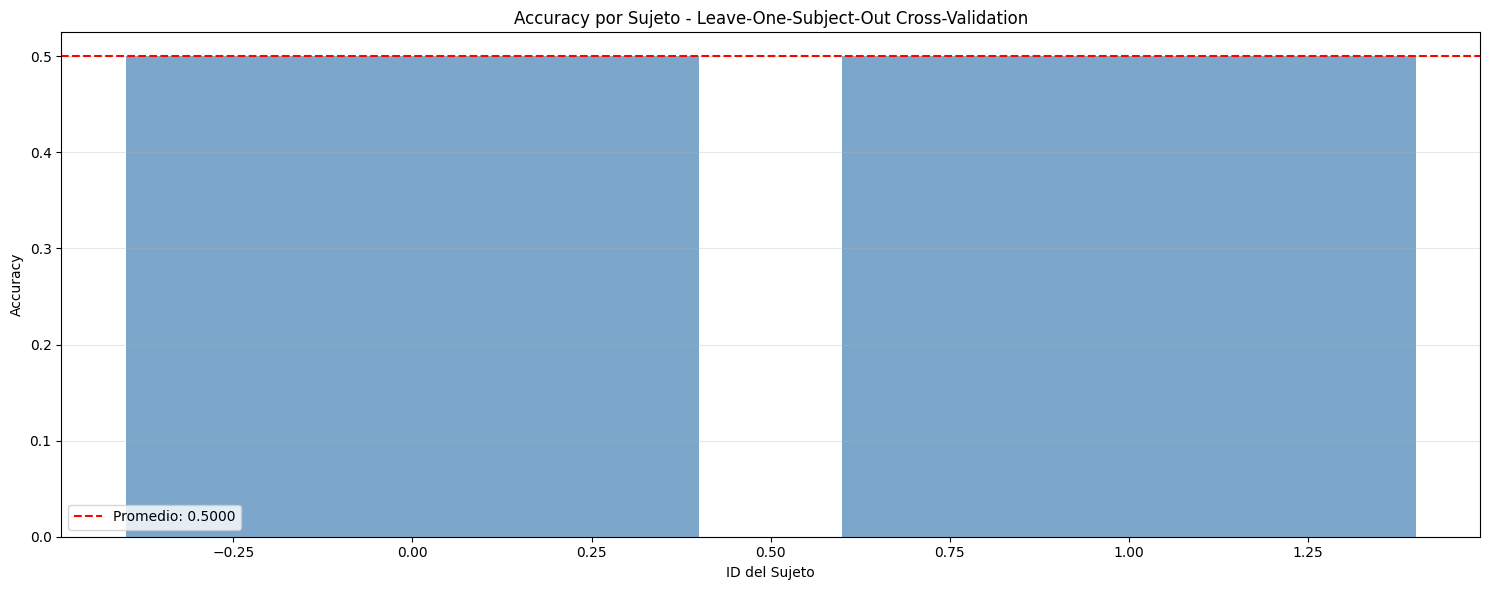

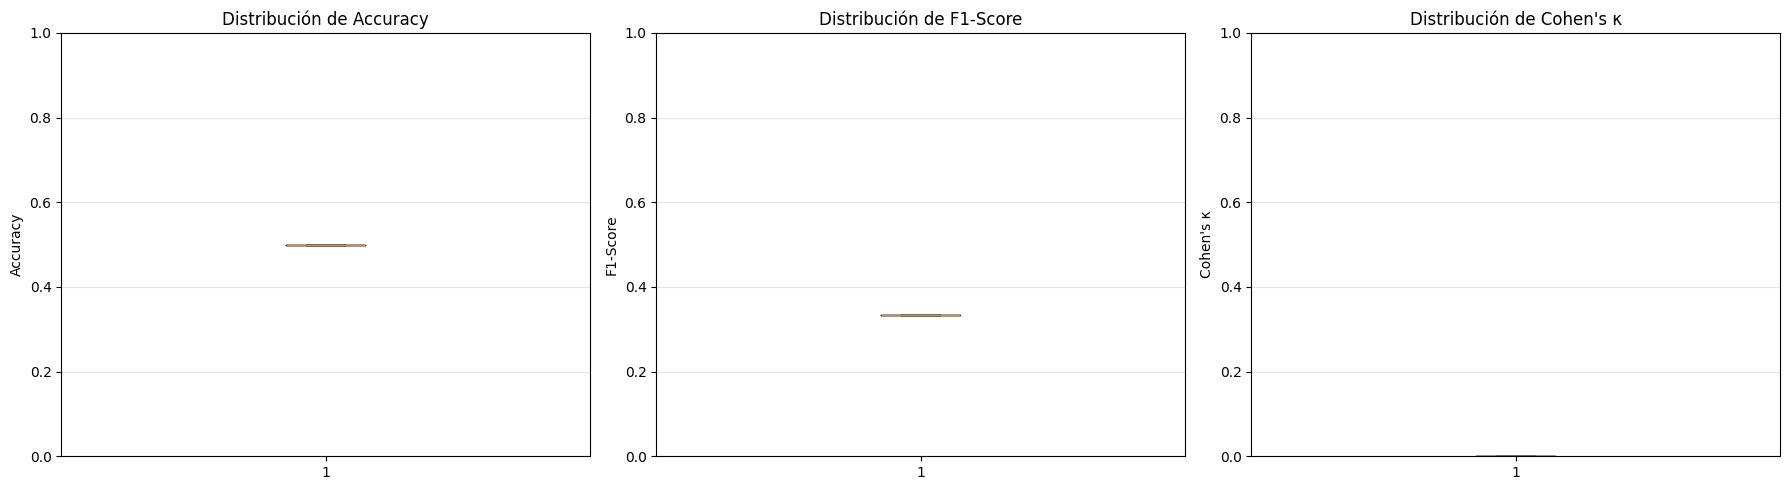


TABLA RESUMEN POR SUJETO:
 subject_id  accuracy  precision  recall  f1_score  cohen_kappa
          0       0.5       0.25     0.5  0.333333          0.0
          1       0.5       0.25     0.5  0.333333          0.0

Visualizaciones guardadas


In [132]:
# Visualizar resultados por sujeto
print("\n" + "="*70)
print("VISUALIZACIÓN DE RESULTADOS")
print("="*70)

# Crear DataFrame con resultados por sujeto
import pandas as pd

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('subject_id')

# Gráfico de barras: Accuracy por sujeto
plt.figure(figsize=(15, 6))
plt.bar(results_df['subject_id'], results_df['accuracy'], alpha=0.7, color='steelblue')
plt.axhline(y=avg_metrics['accuracy'], color='r', linestyle='--', 
            label=f'Promedio: {avg_metrics["accuracy"]:.4f}')
plt.xlabel('ID del Sujeto')
plt.ylabel('Accuracy')
plt.title('Accuracy por Sujeto - Leave-One-Subject-Out Cross-Validation')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(Path(CONFIG['results_dir']) / 'transfer_learning_loso_accuracy_by_subject.png', 
            dpi=150, bbox_inches='tight')
plt.show()

# Gráfico de cajas: Distribución de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['accuracy', 'f1_score', 'cohen_kappa']
titles = ['Accuracy', 'F1-Score', "Cohen's κ"]

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    axes[idx].boxplot(results_df[metric], vert=True)
    axes[idx].set_ylabel(title)
    axes[idx].set_title(f'Distribución de {title}')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(Path(CONFIG['results_dir']) / 'transfer_learning_loso_metrics_distribution.png', 
            dpi=150, bbox_inches='tight')
plt.show()

# Tabla resumen
print("\nTABLA RESUMEN POR SUJETO:")
print(results_df[['subject_id', 'accuracy', 'precision', 'recall', 'f1_score', 'cohen_kappa']].to_string(index=False))

print("\nVisualizaciones guardadas")


In [133]:
# Guardar todos los resultados
print("\n" + "="*70)
print("GUARDANDO RESULTADOS")
print("="*70)

# Crear diccionario completo de resultados
results_to_save = {
    'average_metrics': {
        k: float(v) for k, v in avg_metrics.items() if not isinstance(v, (list, dict))
    },
    'per_subject_results': {
        str(k): {m: float(v) for m, v in metrics.items() if isinstance(v, (int, float))}
        for k, metrics in subject_results.items()
    },
    'all_results': [
        {k: float(v) if isinstance(v, (int, float)) else v for k, v in r.items()}
        for r in all_results
    ],
    'config': CONFIG,
    'timestamp': datetime.now().isoformat()
}

# Guardar JSON
results_json_path = Path(CONFIG['results_dir']) / 'transfer_learning_loso_results.json'
with open(results_json_path, 'w', encoding='utf-8') as f:
    json.dump(results_to_save, f, indent=2, ensure_ascii=False)

print(f"Resultados guardados en: {results_json_path}")

# Guardar CSV
results_csv_path = Path(CONFIG['results_dir']) / 'transfer_learning_loso_results.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"Resultados CSV guardados en: {results_csv_path}")

print("\n" + "="*70)
print("NOTEBOOK COMPLETADO EXITOSAMENTE")
print("="*70)
print(f"\nArchivos generados:")
print(f"- {results_json_path}")
print(f"- {results_csv_path}")
print(f"- {Path(CONFIG['results_dir']) / 'transfer_learning_loso_accuracy_by_subject.png'}")
print(f"- {Path(CONFIG['results_dir']) / 'transfer_learning_loso_metrics_distribution.png'}")
print(f"\nResultados promedio:")
print(f"- Accuracy: {avg_metrics['accuracy']:.4f} ± {avg_metrics['std_accuracy']:.4f}")
print(f"- F1-Score: {avg_metrics['f1_score']:.4f} ± {avg_metrics['std_f1']:.4f}")
print(f"- Cohen's κ: {avg_metrics['cohen_kappa']:.4f}")



GUARDANDO RESULTADOS
Resultados guardados en: results/transfer_learning_loso_results.json
Resultados CSV guardados en: results/transfer_learning_loso_results.csv

NOTEBOOK COMPLETADO EXITOSAMENTE

Archivos generados:
- results/transfer_learning_loso_results.json
- results/transfer_learning_loso_results.csv
- results/transfer_learning_loso_accuracy_by_subject.png
- results/transfer_learning_loso_metrics_distribution.png

Resultados promedio:
- Accuracy: 0.5000 ± 0.0000
- F1-Score: 0.3333 ± 0.0000
- Cohen's κ: 0.0000
